In [47]:
import os
import sys

sys.path.append('/root/diffuser_chain_hd')
# print(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# exit()


import json
import numpy as np
from os.path import join
import pdb

from diffuser.guides.policies import Policy
import diffuser.datasets as datasets
import diffuser.utils as utils

import argparse


class Parser(utils.Parser):
    dataset: str = 'maze2d-xxlarge-v2'
    config: str = 'config.maze2d_390_originalDiffuser_mazexxlarge_test8M_HLarge'


#---------------------------------- setup ----------------------------------#
n_samples = 100

args = Parser().parse_args('diffusion', add_extras=False) # Discovered it later, so had to disable it as I am doing it here, until I test it


[ utils/setup ] Reading config: config.maze2d_390_originalDiffuser_mazexxlarge_test8M_HLarge:maze2d_xxlarge_v2
[ utils/setup ] Using overrides | config: config.maze2d_390_originalDiffuser_mazexxlarge_test8M_HLarge | dataset: maze2d_xxlarge_v2
[ utils/setup ] Setting exp_name to: diffuserdiffuserdiffusion_actW1_jump_action/H384_T256_J1
[ utils/setup ] Made savepath: logs/maze2d-xxlarge-v2/diffuserdiffuserdiffusion_actW1_jump_action/H384_T256_J1
[ utils/setup ] Saved args to logs/maze2d-xxlarge-v2/diffuserdiffuserdiffusion_actW1_jump_action/H384_T256_J1/args.json


In [48]:
env = datasets.load_environment(args.dataset)

args.dataset

'maze2d-xxlarge-v2'

In [49]:
dataset_config = utils.Config(
    args.loader,
    savepath=(args.savepath, "dataset_config.pkl"),
    env=args.dataset,
    horizon=args.horizon,#1000,
    normalizer=args.normalizer,
    preprocess_fns=args.preprocess_fns,
    use_padding=args.use_padding,
    max_path_length=args.max_path_length,
    jump=args.jump,
    jump_action=args.jump_action,
)


render_config = utils.Config(
    args.renderer,
    savepath=(args.savepath, "render_config.pkl"),
    env=args.dataset,
)
args.horizon

[ utils/config ] Imported diffuser.datasets:GoalDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.GoalDataset'>
    env: maze2d-xxlarge-v2
    horizon: 384
    jump: 1
    jump_action: 1
    max_path_length: 300000
    normalizer: LimitsNormalizer
    preprocess_fns: ['maze2d_set_terminals']
    use_padding: False

[ utils/config ] Saved config to: logs/maze2d-xxlarge-v2/diffuserdiffuserdiffusion_actW1_jump_action/H384_T256_J1/dataset_config.pkl

[ utils/config ] Imported diffuser.utils:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: maze2d-xxlarge-v2

[ utils/config ] Saved config to: logs/maze2d-xxlarge-v2/diffuserdiffuserdiffusion_actW1_jump_action/H384_T256_J1/render_config.pkl



384

In [50]:
dataset = dataset_config()
renderer = render_config()

Using the original dataset


load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.48it/s]


[ utils/preprocessing ] Segmented maze2d-xxlarge-v2 | 178 paths | min length: 69 | max length: 211296 | mean length: 43709.668539325845
[ datasets/buffer ] Finalized replay buffer | 179 episodes
[ datasets/buffer ] Fields:
    observations: (179, 300000, 4)
    rewards: (179, 300000, 1)
    actions: (179, 300000, 2)
    terminals: (179, 300000, 1)
    next_observations: (179, 300000, 4)
    normed_observations: (179, 300000, 4)
    normed_actions: (179, 300000, 2)


[ 73644  18852 128238  18801 145350  46393  71605  37546  77625  15505
  20279 211295  29439  26929  86689  47674   5171   1429   8957   1436
 112991  30010   4088 134941  42324  40469  36802  46676   6083  23219
 133836 163149  53429  36538  48055  35483  30470  45722   2925  14437
  23601  48904  15261  22277  10379   3634  80979   1907   7506  51491
   2791  21187  23370 101866  27161  74967  19017 107738  13528  64694
  14157  15421  21742 111537  42206  17892  44790  40746 109247   4615
  41745  18213  91612  38940  79675  16989  39472  22351  49053   6659
  36364   3190  70966  23535  68636  45003  15930   6992  38978  30531
  55968  81520  62084  33931   9046  62117  69475  12379   8028   2643
   9370   2617  20341  78897 136818  21016  22004  24063  57570  75719
  67067  47404  15212  37225   1584  86590  54395   6269   3063  47566
  41651 117427  21054  39226  63279   2371   6395  10872 141132  50122
  22650 139044   1735  38554  56078  66726  12638  92200  30734  35521
   741

(array([66., 41., 31., 16.,  7.,  6.,  8.,  3.,  0.,  1.]),
 array([6.800000e+01, 2.119070e+04, 4.231340e+04, 6.343610e+04,
        8.455880e+04, 1.056815e+05, 1.268042e+05, 1.479269e+05,
        1.690496e+05, 1.901723e+05, 2.112950e+05]),
 <BarContainer object of 10 artists>)

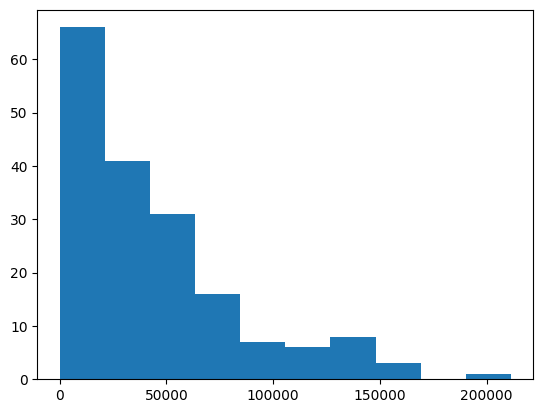

In [51]:
import matplotlib.pyplot as plt
print(dataset.path_lengths)
plt.hist(dataset.path_lengths)

/tmp/ipykernel_751/3092604912.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


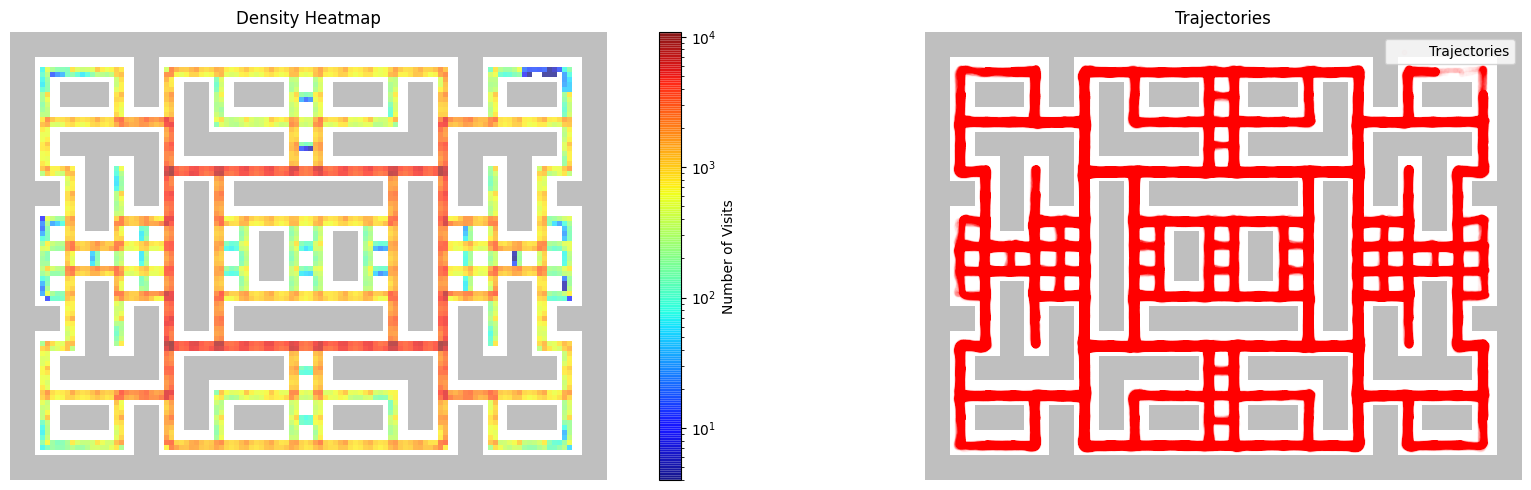

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import gym
import d4rl

def draw_aligned_heatmap_on_environment(env, num_trajs=1000, histogram_scale=5):
    _background = env.maze_arr == 10 

    x_points = []
    z_points = []
    for i in range(num_trajs):
        idx = np.random.randint(0, len(dataset))
        trj = dataset.normalizer.unnormalize(dataset[idx].trajectories[:,dataset.normalizer.action_dim:], "observations")
        x_points.extend(trj[:, 1])
        z_points.extend(trj[:, 0])

    x_points = np.array(x_points)
    z_points = np.array(z_points)

    min_x, max_x = 0, _background.shape[1]
    min_z, max_z = 0, _background.shape[0]


    # Calculate histogram bins
    bins_x = int(histogram_scale * (max_x - min_x))
    bins_z = int(histogram_scale * (max_z - min_z))
    pos_traj, x_edges, z_edges = np.histogram2d(x_points, z_points, bins=[bins_x, bins_z], range=[[min_x-0.5, max_x-0.5], [min_z-0.5, max_z-0.5]])
    pos_traj = pos_traj.T
    pos_traj = np.flipud(pos_traj)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    ax = axes[0]

    # Plot environment background
    ax.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
        extent=[min_x, max_x, min_z, max_z],
        origin='lower',
        alpha=0.5,
    )

    # Plot heatmap
    cax = ax.imshow(
        pos_traj,
        cmap='jet',
        interpolation='nearest',
        norm=LogNorm(),
        extent=[min_x, max_x, min_z, max_z],
        alpha=0.7,
    )
    plt.colorbar(cax, ax=ax, label='Number of Visits')
    ax.axis("off")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Density Heatmap')


    ax = axes[1]

    ax.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
        origin='lower',
        alpha=0.5,
    )

    ax.scatter(x_points, z_points, color='red', s=10, alpha=0.01, label='Trajectories')
    ax.axis("off")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    ax.set_title('Trajectories')

    plt.legend()
    plt.tight_layout()
    plt.show()

env = datasets.load_environment(args.dataset)
draw_aligned_heatmap_on_environment(env, num_trajs=10000, histogram_scale=5)